In [2]:
import os
import numpy as np
import scipy.stats as st
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('figure', dpi=200)
plt.rc('legend', fontsize=9)
import warnings
warnings.filterwarnings('ignore')

In [3]:
def concatenate_performance(dir_path):
    path = Path(dir_path)
    (_, dir_names, _) = next(os.walk(path))  # Get subdirectories
    memmaps = []
    for sweep_dir in [d for d in dir_names if d.startswith("sweep")]:  # Filter for "sweep" prefix
        # Open the performance memmaps in each subdirectory:
        memmaps.append(np.lib.format.open_memmap(str(path / sweep_dir / 'performance.npy'), mode='r'))
    concatenated = np.concatenate(memmaps)  # concatenate all memmaps together (note: loads them all into memory)
    del memmaps
    performance_memmap = np.lib.format.open_memmap(str(path / 'concatenated_performance.npy'), shape=concatenated.shape, dtype=concatenated.dtype, mode='w+')
    performance_memmap[:] = concatenated
    del concatenated
    del performance_memmap
    
def combine_results(results):
    num_configs, num_runs, num_policies, num_evals = results.shape
    mean_evals = np.mean(results, axis=3)
    mean_runs = np.mean(mean_evals, axis=1)
    sem_runs = st.sem(mean_evals, axis=1)
    lower, upper = st.t.interval(0.90, num_runs-1, loc=mean_runs, scale=sem_runs)
    return mean_runs, lower, upper

def load_results(alg):
    return np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office4/'+alg+'/concatenated_performance.npy', mode='r')['results']

def load_performance(alg):
    return np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office4/'+alg+'/concatenated_performance.npy', mode='r')

In [4]:
etd_algs = ['ace-trace-etd-episodic', 'ace-trace-etd-uniform', 'offpac-etd', 'ace-direct-etd-episodic', 'ace-direct-etd-uniform']
tdrc_algs = ['ace-trace-tdrc-episodic', 'ace-trace-tdrc-uniform', 'offpac-tdrc', 'ace-direct-tdrc-episodic', 'ace-direct-tdrc-uniform']
algs = etd_algs + tdrc_algs

# for alg in algs:
#     concatenate_performance('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office4/' + alg)
#     print(alg)

In [5]:
experience = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office4/offpac-etd/sweep0/experience.npy', mode='r')
print(experience.shape)

(30, 100000)


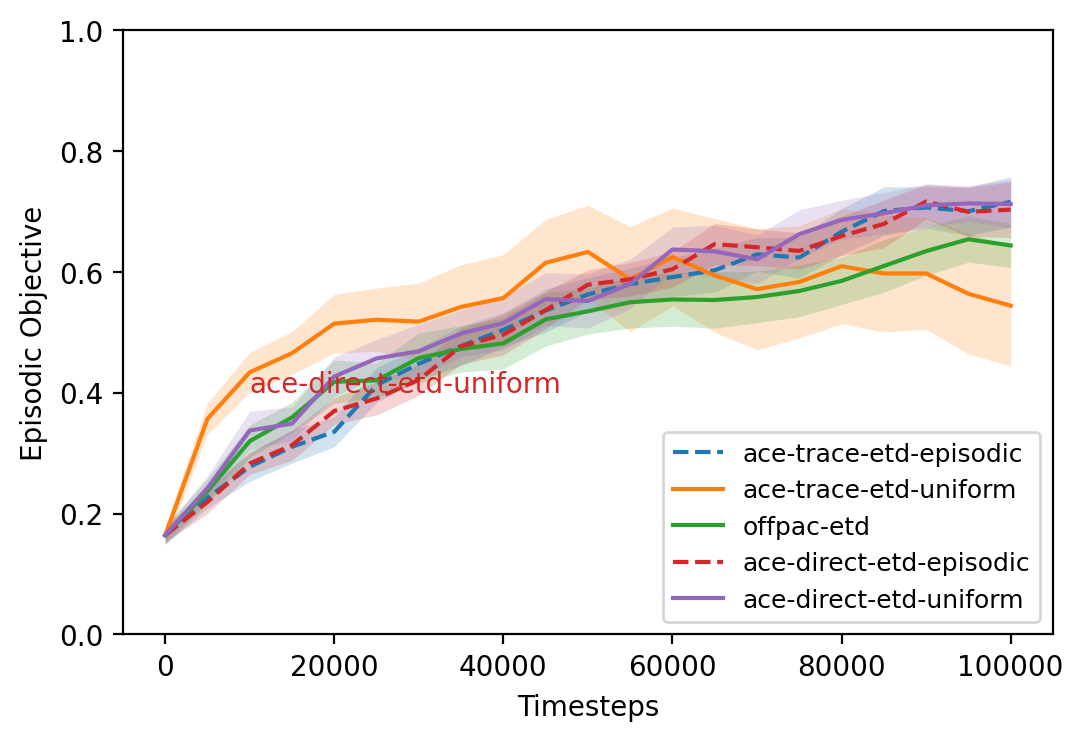

In [21]:
cutoff = 21
fig, ax = plt.subplots()
for alg in etd_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['episodic'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    
    x = np.linspace(0, 100000, 21)[:cutoff]
    y = means[best_config][:cutoff]
    
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, xy=(10000, .4), color=color)
#         elif 'episodic' in alg:
#             ax.annotate(alg, xy=(28000, -1000), xytext=(10000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'trace' in alg:
        color = 'tab:orange'
#         if 'uniform' in alg:
#             ax.annotate(alg, xy=(21500, -345), xytext=(20000, -480), color=color, arrowprops=dict(arrowstyle="->", color=color))
#         elif 'episodic' in alg:
#             ax.annotate(alg, xy=(80000, -1000), xytext=(60000, -900), color=color, arrowprops=dict(arrowstyle="->", color=color))
    elif 'offpac' in alg:
        color = 'tab:green'
#         ax.annotate(alg, xy=(5500, -600), xytext=(15000, -700), color=color, arrowprops=dict(arrowstyle="->", color=color))
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle)
    ax.fill_between(x, lower[best_config][:cutoff], upper[best_config][:cutoff], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(0,1)
ax.legend(loc="lower right")
plt.savefig('vo_epi_etd.png', bbox_inches="tight")

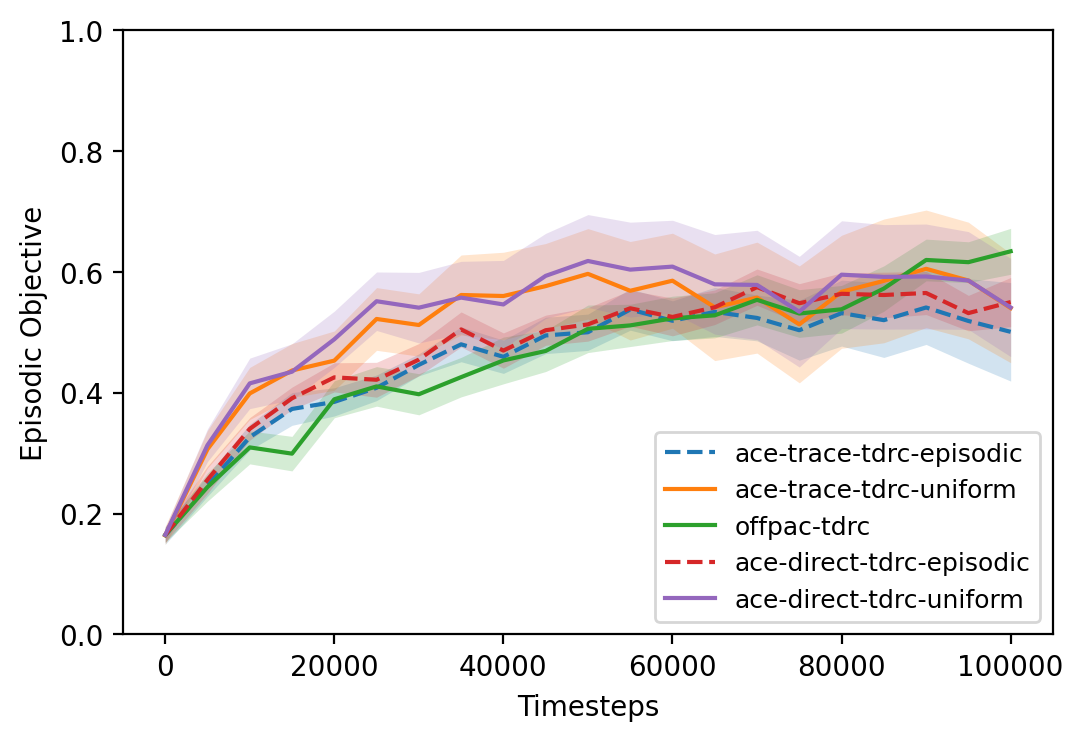

In [20]:
cutoff = 21
fig, ax = plt.subplots()
for alg in tdrc_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['episodic'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    
    x = np.linspace(0, 100000, 21)[:cutoff]
    y = means[best_config][:cutoff]
    
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle)
    ax.fill_between(x, lower[best_config][:cutoff], upper[best_config][:cutoff], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(0,1)
ax.legend(loc="lower right")
plt.savefig('vo_epi_tdrc.png', bbox_inches="tight")

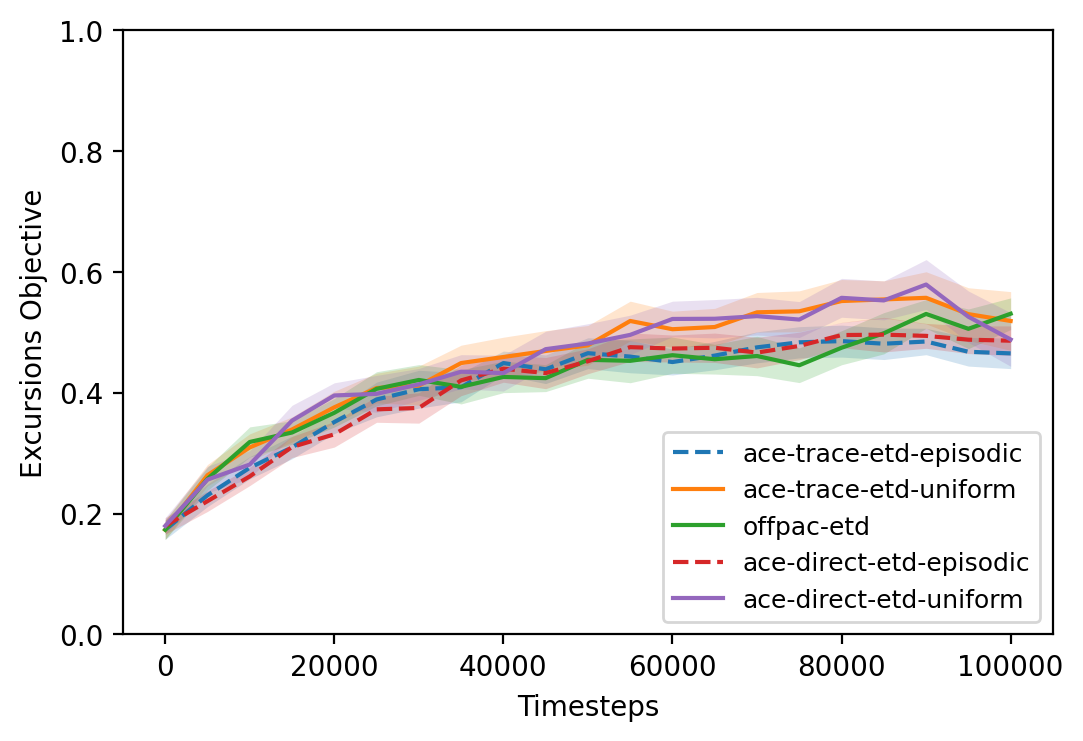

In [19]:
cutoff = 21
fig, ax = plt.subplots()
for alg in etd_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['excursions'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, 21)[:cutoff]
    y = means[best_config][:cutoff]
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle)
    ax.fill_between(x, lower[best_config][:cutoff], upper[best_config][:cutoff], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
ax.set_ylim(0,1)
ax.legend(loc="lower right")
plt.savefig('vo_exc_etd.png', bbox_inches="tight")

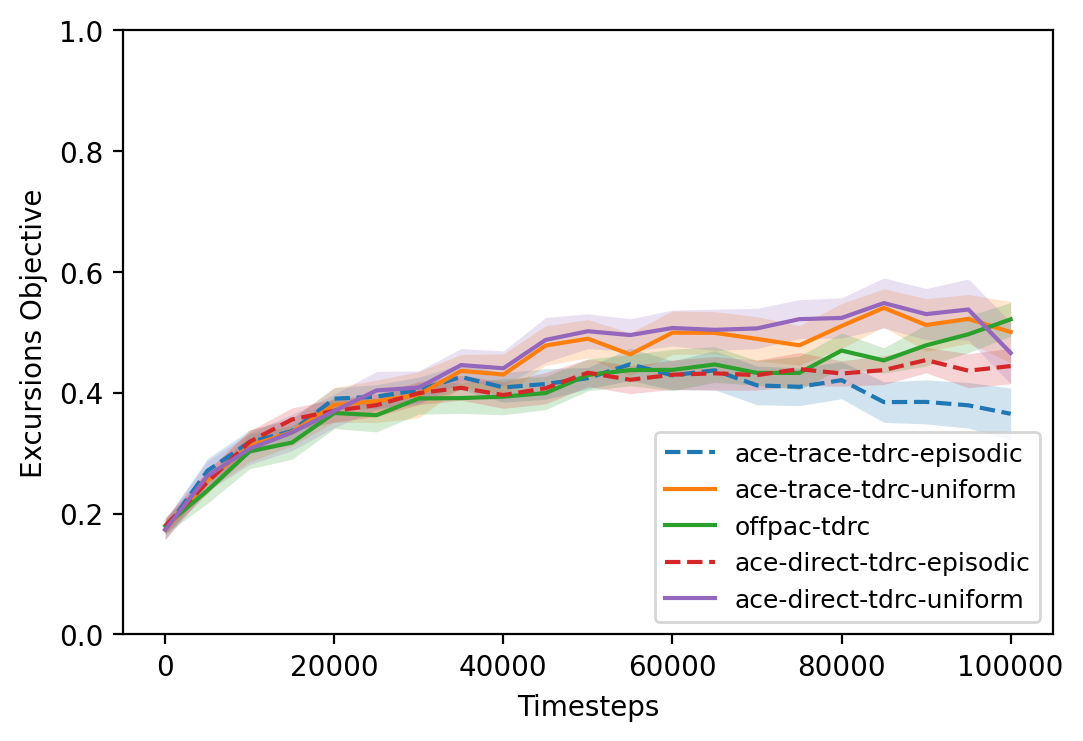

In [18]:
cutoff = 21
fig, ax = plt.subplots()
for alg in tdrc_algs:
    results = load_results(alg)
    means, lower, upper = combine_results(results['excursions'])
    del results
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, 21)[:cutoff]
    y = means[best_config][:cutoff]
    linestyle = '--' if 'episodic' in alg else '-'
    lines = ax.plot(x, y, label=alg, linestyle=linestyle)
    ax.fill_between(x, lower[best_config][:cutoff], upper[best_config][:cutoff], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
ax.set_ylim(0,1)
ax.legend(loc="lower right")
plt.savefig('vo_exc_tdrc.png', bbox_inches="tight")

In [ ]:
# # code to compare the best-performing parameters for ace-direct and ace-trace:
# performance = load_performance('ace-trace-etd-uniform')
# parameters = performance['parameters']
# results = performance['results']

# means, lower, upper = combine_results(results['episodic'])
# mean_returns = np.mean(means, axis=1)
# best_config = np.nanargmax(mean_returns)
# best_parameters = parameters[best_config]

# print(parameters.dtype.names)
# print(best_parameters)

# performance = load_performance('ace-direct-etd-uniform')
# parameters = performance['parameters']
# results = performance['results']

# means, lower, upper = combine_results(results['episodic'])
# mean_returns = np.mean(means, axis=1)
# best_config = np.nanargmax(mean_returns)
# best_parameters = parameters[best_config]
# print(best_parameters)

In [22]:
# Visualize state/state-action visits:
# Generate experience:
import gym
import gym_virtual_office
import numpy as np

num_timesteps = 100000

mu = np.array([.23,.3,.27,.2])
state_visits = np.zeros((9,9))

env = gym.make('VirtualOffice-v0').unwrapped
env.seed(14)
rng = env.np_random

env.reset()
assert type(env.agent_pos) is tuple
state_visits[env.agent_pos] += 1
for t in range(num_timesteps):
    a_t = rng.choice(env.action_space.n, p=mu)
    _, r_tp1, terminal, _ = env.step(a_t)

    assert type(env.agent_pos) is tuple
    state_visits[env.agent_pos] += 1
    
    if terminal:
        o_tp1 = env.reset()
        assert type(env.agent_pos) is tuple
        state_visits[env.agent_pos] += 1

# state_visits /=  np.sum(state_visits)
print(state_visits.T)

[[   0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 1660. 2165. 2875.    0.  639.  436.  183.    0.]
 [   0. 2204. 2725. 3049. 2292. 1219.  637.  246.    0.]
 [   0. 3164. 3589. 4434.    0.  934.  627.  232.    0.]
 [   0. 5301. 4742. 5755.    0.    0.    0.    0.    0.]
 [   0. 3892. 4547. 5707.    0.  873.  617.  263.    0.]
 [   0. 3357. 4264. 4912. 3583. 1756.  997.  400.    0.]
 [   0. 3395. 4737. 6466.    0. 1315.  942.  381.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.]]


In [18]:
# Code to plot the best-performing parameter values subject to constraints (here lambda=0):

# trace_decay_rate = 0.

# fig, ax = plt.subplots()

# # Plot OffPAC results:
# op_mask = (op_parameters['lambda'] == trace_decay_rate)
# op_best_config = np.nanargmax(op_total_return[op_mask])
# x = op_memmap['performance']['timesteps'][0][0]
# y = op_mean_results[op_mask][op_best_config]
# cis = op_sem_results[op_mask][op_best_config] * st.t.ppf((1.0 + 0.95) / 2, op_num_eval_runs - 1)
# label = create_label(op_parameters[op_mask][op_best_config])
# ax.errorbar(x, y, yerr=[cis, cis], label=label)

# # Plot ACE results:
# ace_mask = (ace_parameters['lambda'] == trace_decay_rate)
# ace_best_config = np.nanargmax(ace_total_return[ace_mask])
# x = ace_memmap['performance']['timesteps'][0][0]
# y = ace_mean_results[ace_mask][ace_best_config]
# cis = ace_sem_results[ace_mask][ace_best_config] * st.t.ppf((1.0 + 0.95) / 2, ace_num_eval_runs - 1)
# label = create_label(ace_parameters[ace_mask][ace_best_config])
# ax.errorbar(x, y, yerr=[cis, cis], label=label)

# plt.legend(loc="lower right")
# plt.title('Virtual Office')
# plt.xlabel('Timesteps')
# plt.ylabel('Episode returns')

In [19]:
# # Code to visualize a learned policy:
# # Currently doesn't work because I need to find a way around openai gym rendering in a new window (which obviously doesn't work on compute canada).

# from src.algorithms.ace import LinearACE
# import gym
# import gym_virtual_office

# env = gym.make('VirtualOffice-v0').unwrapped
# env.seed(14)
# rng = env.np_random

# policies_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office/offpac/sweep0/policies.npy', mode='r')
# policy = policies_memmap[op_mask][op_best_config]['policies']['weights'][0][-1]
# actor = LinearACE(*policy.shape, 0.)

# # TODO: write code to create and display a video:
# # o_t = env.reset()['image'].ravel()
# # for t in range(1000):
# #     a_t = rng.choice(env.action_space.n, p=actor.pi(o_t))
# #     o_tp1, r_tp1, terminal, _ = env.step(a_t)
# #     o_tp1 = o_tp1['image'].ravel()
# #     o_t = o_tp1
# #     if terminal:
# #         break

In [20]:
# def create_label(p):
#     return f'{"OffPAC" if p["eta"] == 0. else "ACE"} \
# \n  $\\alpha_a$:{p["alpha_a"]} \
# \n  $\\alpha_w$:{p["alpha_w"]} \
# \n  $\\alpha_v$:{p["alpha_v"]} \
# \n  $\\lambda$:{p["lambda"]} \
# \n  $\\eta$:{p["eta"]}'